In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
asset_classes = ['VTI', 'EFA', 'EEM', 'HYG', 'LQD', 'IEF', 'IGOV']

ff = pd.read_csv(r'./data/FF-5-Daily.csv', index_col=0, parse_dates=True)
adj_prices = pd.read_csv(r'./data/adj_prices.csv', index_col=0, parse_dates=True)

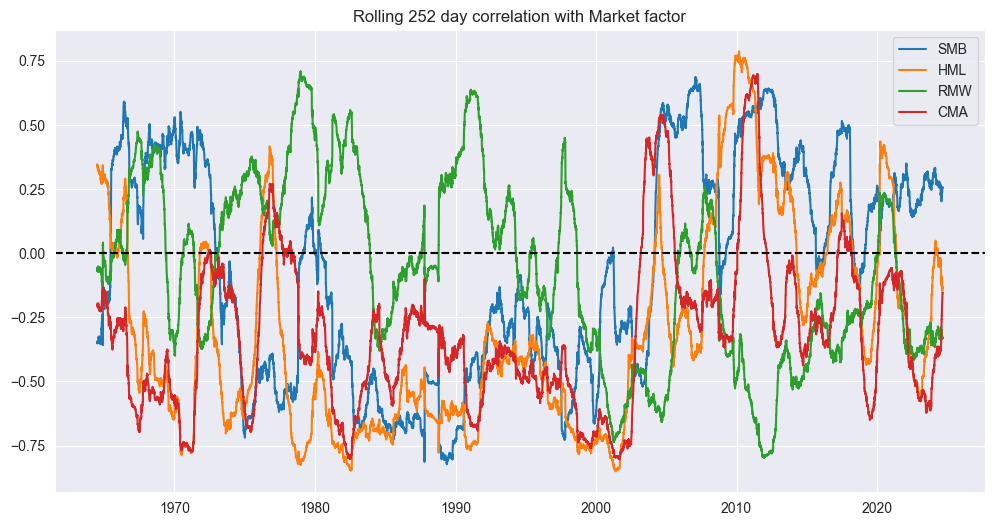

In [ ]:
# Compute the rolling 252 day correlations of each of the Fama-French factors with the Market factor
rolling_corr = pd.DataFrame(index=ff.index, columns=ff.columns)
for factor in ff.columns:
    rolling_corr[factor] = ff['Mkt-RF'].rolling(window=252).corr(ff[factor])

# Eliminate the Mkt-RF column
rolling_corr = rolling_corr.drop(columns=['Mkt-RF', 'RF'])

# Plot the rolling correlation. Add a dotted line at 0 for reference
ax, fig = plt.subplots(figsize=(12, 6))
plt.plot(rolling_corr)
plt.axhline(0, color='black', linestyle='--')
plt.legend(rolling_corr.columns)
plt.title('Rolling 252 day correlation with Market factor')
plt.show()

In [39]:
# Convert daily prices to monthly returns
monthly_prices = adj_prices.resample('M').last()
monthly_returns = monthly_prices.pct_change()

# Resample the Fama-French factors to monthly and divide all columns by 100 except the RF column
monthly_ff = ff.resample('M').last() / 100
monthly_ff['RF'] = monthly_ff['RF'] * 100

In [40]:
monthly_ff.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2024-04-30,-0.0167,-0.0027,-0.0026,-0.0061,0.0063,0.021
2024-05-31,0.0068,-0.0010,0.0095,0.0103,0.0091,0.020
2024-06-30,-0.0035,0.0100,0.0128,-0.0019,0.0072,0.022
2024-07-31,0.0153,-0.0097,-0.0132,0.0044,0.0143,0.021
2024-08-31,0.0098,-0.0056,0.0004,-0.0020,-0.0014,0.022


In [41]:
# Subtract RF rate from the monthly returns
er = monthly_returns.sub(monthly_ff['RF'], axis=0)

# Merge the monthly returns with the monthly Fama-French factors
monthly_data = pd.merge(er, monthly_ff, left_index=True, right_index=True)

In [42]:
monthly_data.tail()

,EEM,EFA,HYG,IEF,IGOV,LQD,VTI,Mkt-RF,SMB,HML,RMW,CMA,RF
2024-04-30,-0.023191,-0.053432,-0.034513,-0.052298,-0.055317,-0.053430,-0.064440,-0.0167,-0.0027,-0.0026,-0.0061,0.0063,0.021
2024-05-31,-0.000483,0.030602,-0.003661,-0.001998,-0.003538,0.002137,0.027585,0.0068,-0.0010,0.0095,0.0103,0.0091,0.020
2024-06-30,0.004180,-0.040267,-0.017207,-0.009830,-0.029455,-0.016037,0.008789,-0.0035,0.0100,0.0128,-0.0019,0.0072,0.022
2024-07-31,-0.012547,0.004916,0.002523,0.007972,0.012929,0.005381,-0.002085,0.0153,-0.0097,-0.0132,0.0044,0.0143,0.021
2024-08-31,-0.012221,0.010603,-0.006526,-0.008542,0.006557,-0.003295,-0.000684,0.0098,-0.0056,0.0004,-0.0020,-0.0014,0.022


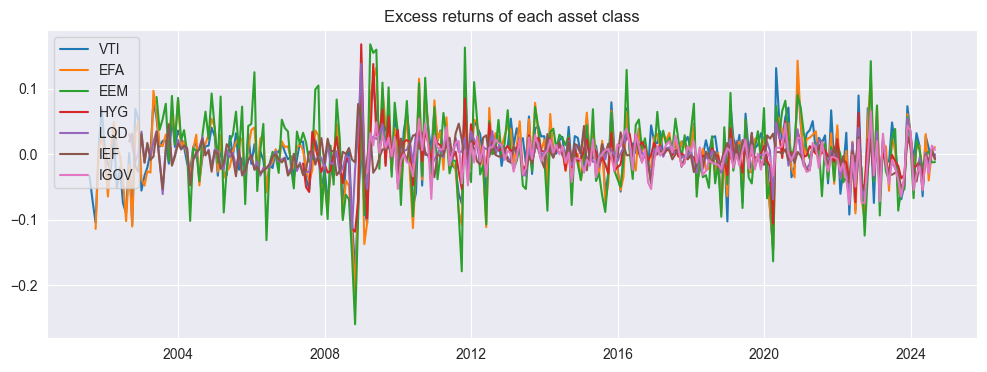

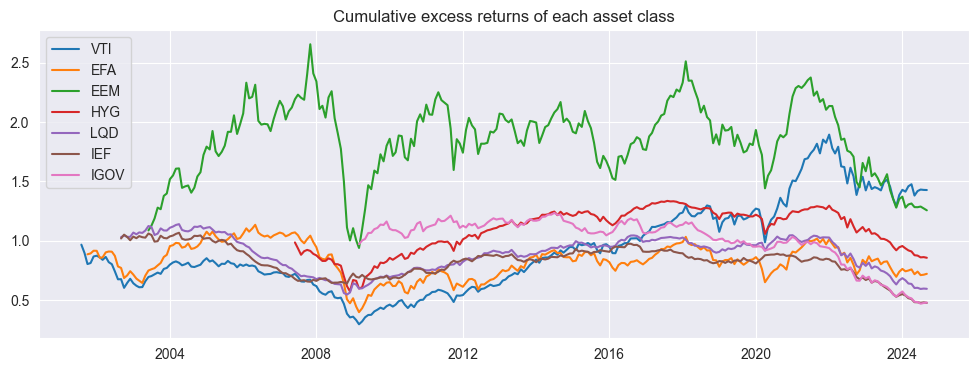

In [81]:
# Plot returns of the asset classes as time series
ax, fig = plt.subplots(figsize=(12, 4))
plt.plot(monthly_data[asset_classes])
plt.legend(asset_classes, loc='upper left')
plt.title('Excess returns of each asset class')
plt.show()

# Plot cumulative excess returns of the asset classes
cum_er = (1 + monthly_data[asset_classes]).cumprod()
ax, fig = plt.subplots(figsize=(12, 4))
plt.plot(cum_er)
plt.legend(asset_classes)
plt.title('Cumulative excess returns of each asset class')
plt.show()

In [54]:
# Create a function that does the regression and saves the predicted returns and error term in each of the dataframes with the column name as the ETF
def factor_model_regression(df, etfs):

    betas_df = pd.DataFrame(index=etfs, columns=['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])
    predictions_df = pd.DataFrame(index=df.index, columns=etfs)
    errors_df = pd.DataFrame(index=df.index, columns=etfs)
    rsquared = pd.Series(index=etfs)
    
    for i in etfs:
        # Build a regression dataframe by selecting each of the ETFs and adding the Fama-French factors, drop the NA values for that dataframe
        reg_df = df[[i, 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].dropna()

        # Define the dependent and independent variables
        y = reg_df[i]
        X = sm.add_constant(reg_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])

        model = sm.OLS(y, X).fit()
        betas_df.loc[i] = model.params

        # Save the predictions and errors
        predictions_df[i] = model.predict(X)
        errors_df[i] = model.resid
        rsquared[i] = model.rsquared
    
    return betas_df, predictions_df, errors_df, rsquared

In [58]:
betas, predicted_er, errors, r_squared = factor_model_regression(monthly_data, asset_classes)

In [59]:
betas

,const,Mkt-RF,SMB,HML,RMW,CMA
VTI,0.002363,0.415746,-1.293036,-1.150247,0.014951,1.573162
EFA,0.000093,0.827184,-1.063032,-1.218034,-0.08183,1.091144
EEM,0.00296,1.097408,-0.914948,-1.428216,0.658056,1.179429
HYG,-0.000076,0.421829,-0.502151,-0.629322,0.762159,0.773868
LQD,-0.001059,0.42479,-0.177848,-0.36395,0.934986,0.255838
IEF,-0.002004,0.356991,-0.072072,0.156781,0.740915,-0.207663
IGOV,-0.002314,1.000093,-0.856577,-0.034967,1.605882,-0.220294


IndexError: list index out of range

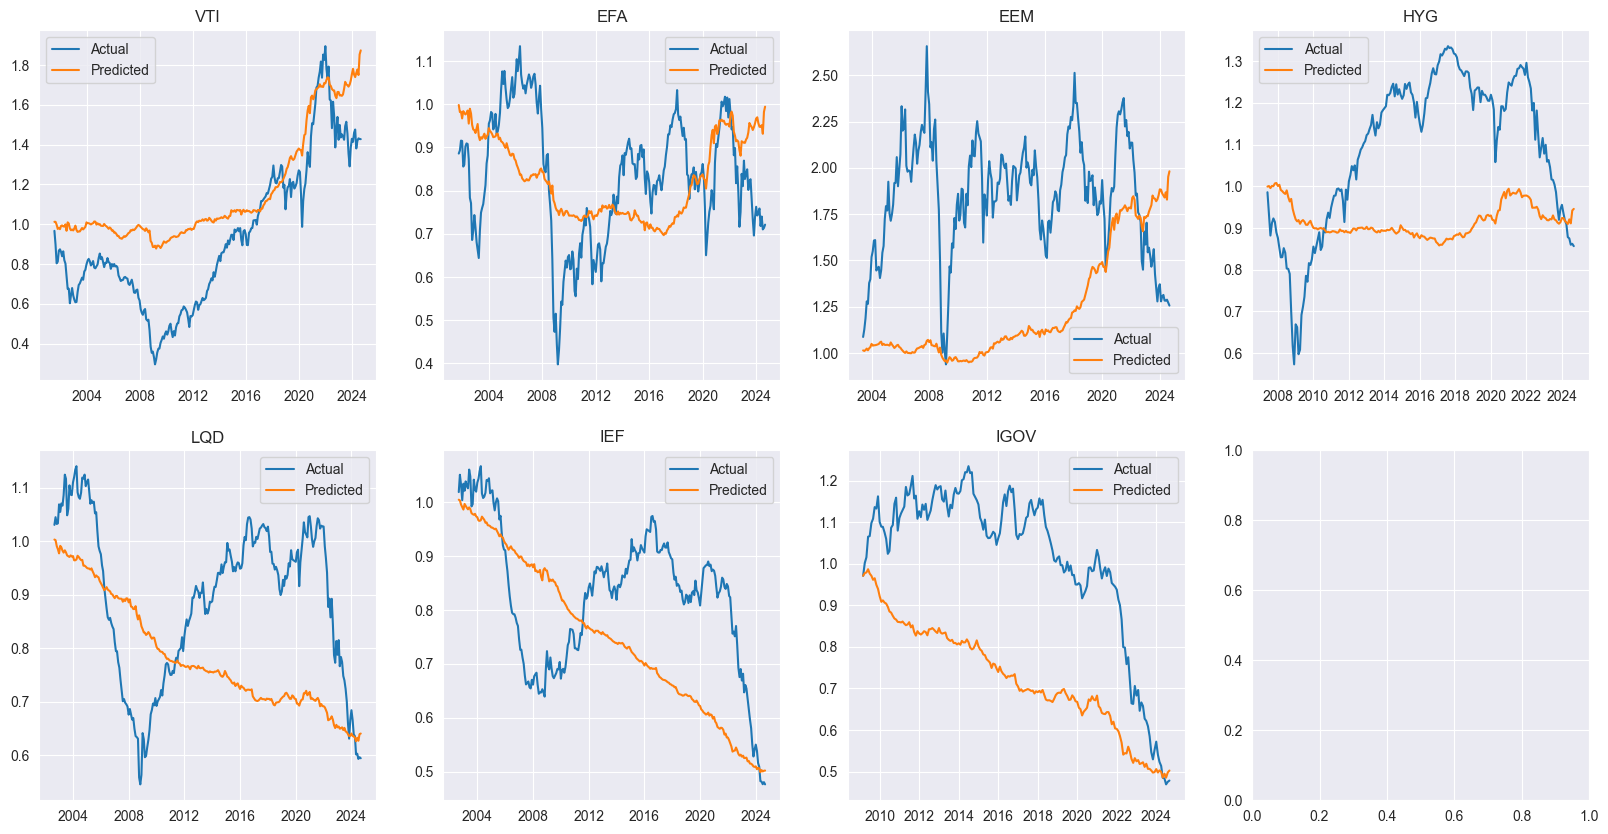

In [53]:
# Plot the cumulative predicted returns vs the actual cumulative returns for each asset class
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(ax.flatten()):
    ax.plot((1 + monthly_data[asset_classes[i]]).cumprod(), label='Actual')
    ax.plot((1 + predicted_er[asset_classes[i]]).cumprod(), label='Predicted')
    ax.legend()
    ax.set_title(asset_classes[i])

plt.show()

In [48]:
# Display r_squared series in a nice format
display(r_squared.to_frame(f'R-Squared'))

,R-Squared
VTI,0.068601
EFA,0.062770
EEM,0.052248
HYG,0.051188
LQD,0.052354
IEF,0.054177
IGOV,0.226183


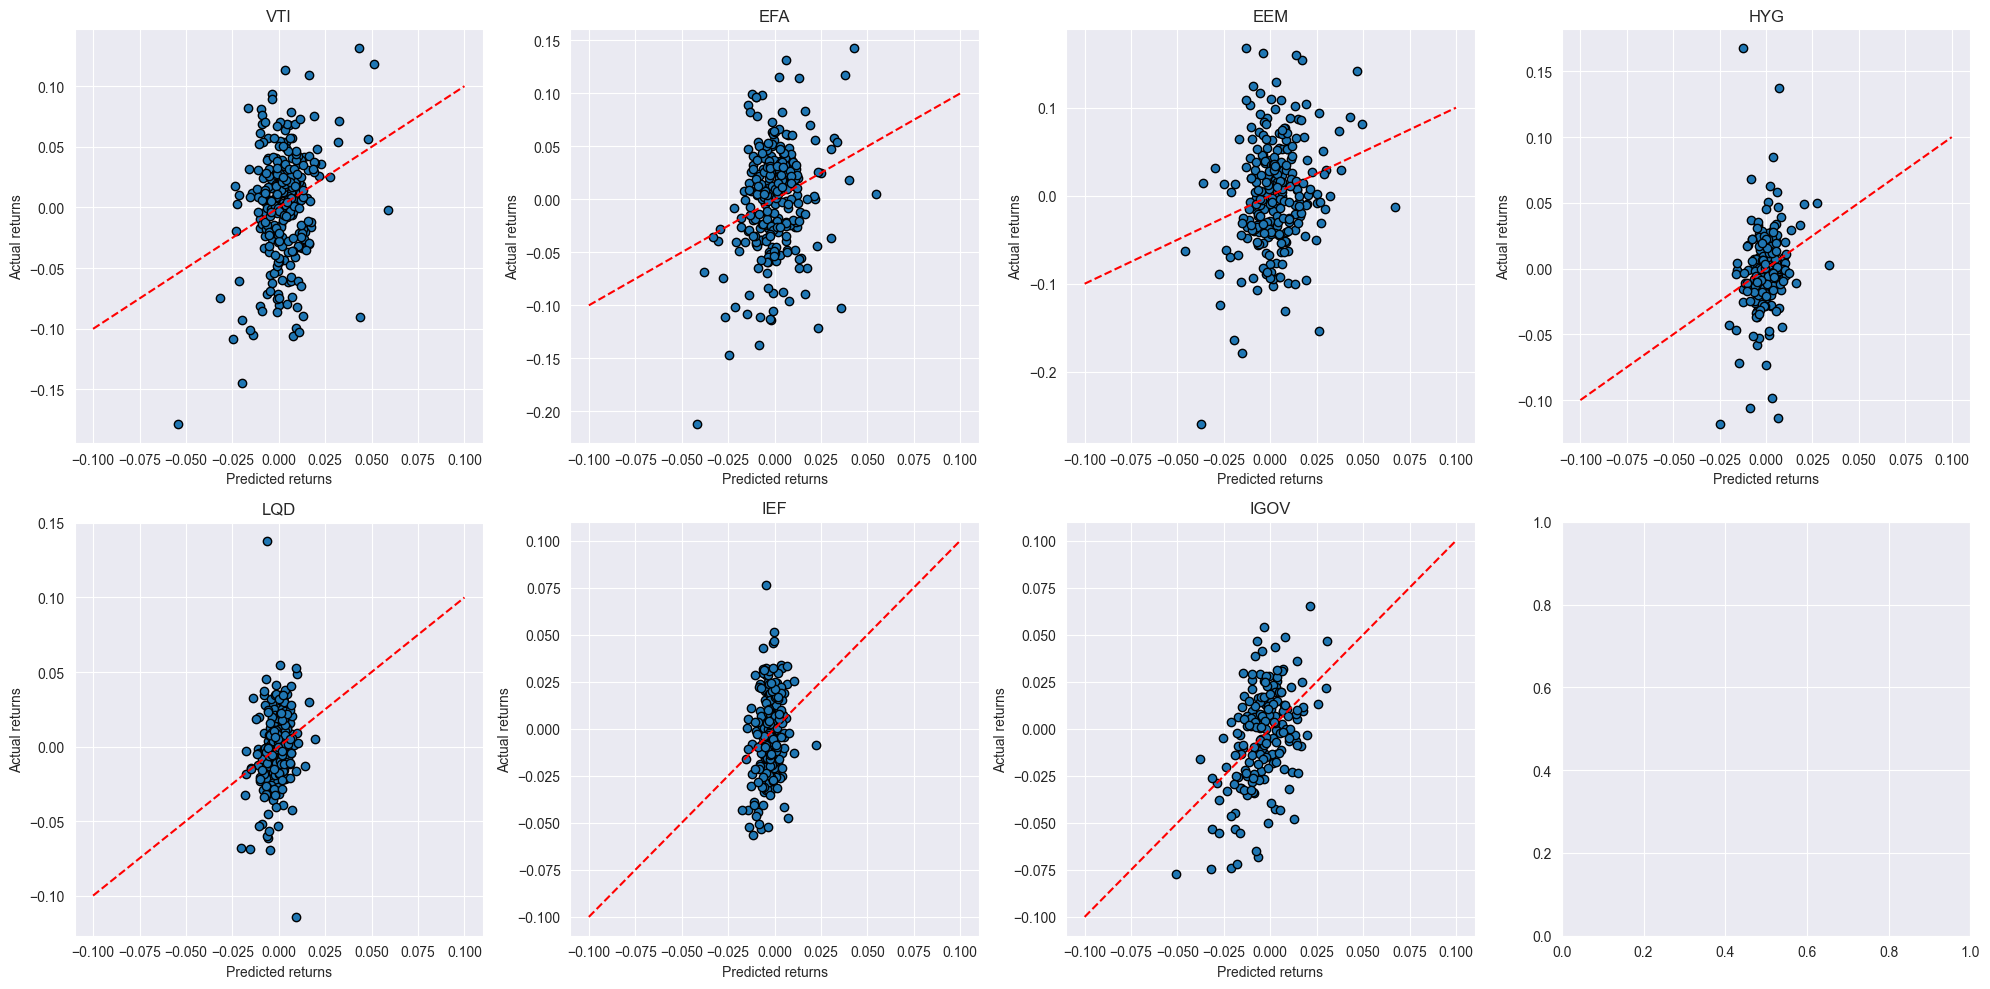

In [49]:
# Plot the predicted returns against the actual returns. Add a 45 degree line for reference. Do a grid of 2x4 plots
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, asset in enumerate(asset_classes):
    ax[i//4, i%4].scatter(predicted_er[asset], monthly_data[asset], edgecolor='black')
    ax[i//4, i%4].plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
    ax[i//4, i%4].set_title(asset)
    ax[i//4, i%4].set_xlabel('Predicted returns')
    ax[i//4, i%4].set_ylabel('Actual returns')
    ax[i//4, i%4].grid(True)

plt.tight_layout()
plt.show()


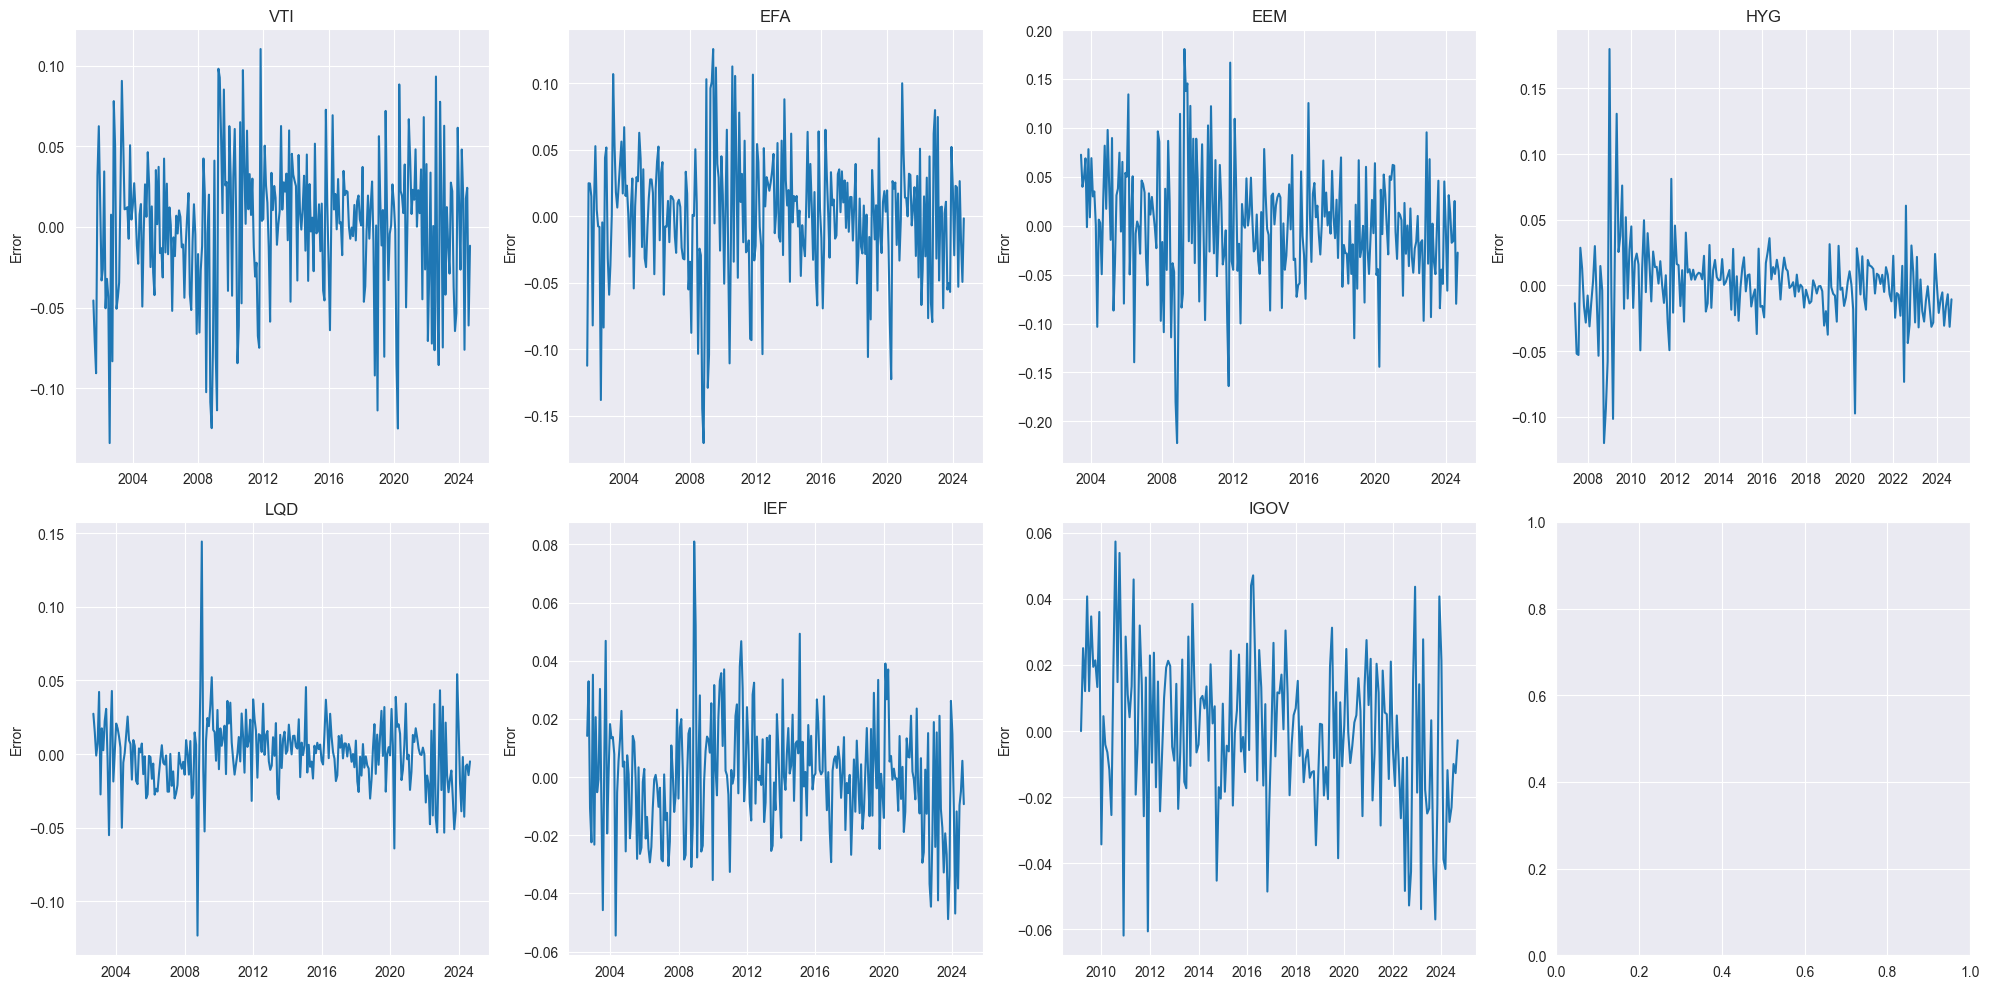

In [50]:
# Plot the errors through time. Do a grid of 2x4 plots
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, asset in enumerate(asset_classes):
    ax[i//4, i%4].plot(errors[asset])
    ax[i//4, i%4].set_title(asset)
    ax[i//4, i%4].set_ylabel('Error')
    ax[i//4, i%4].grid(True)

plt.tight_layout()
plt.show()

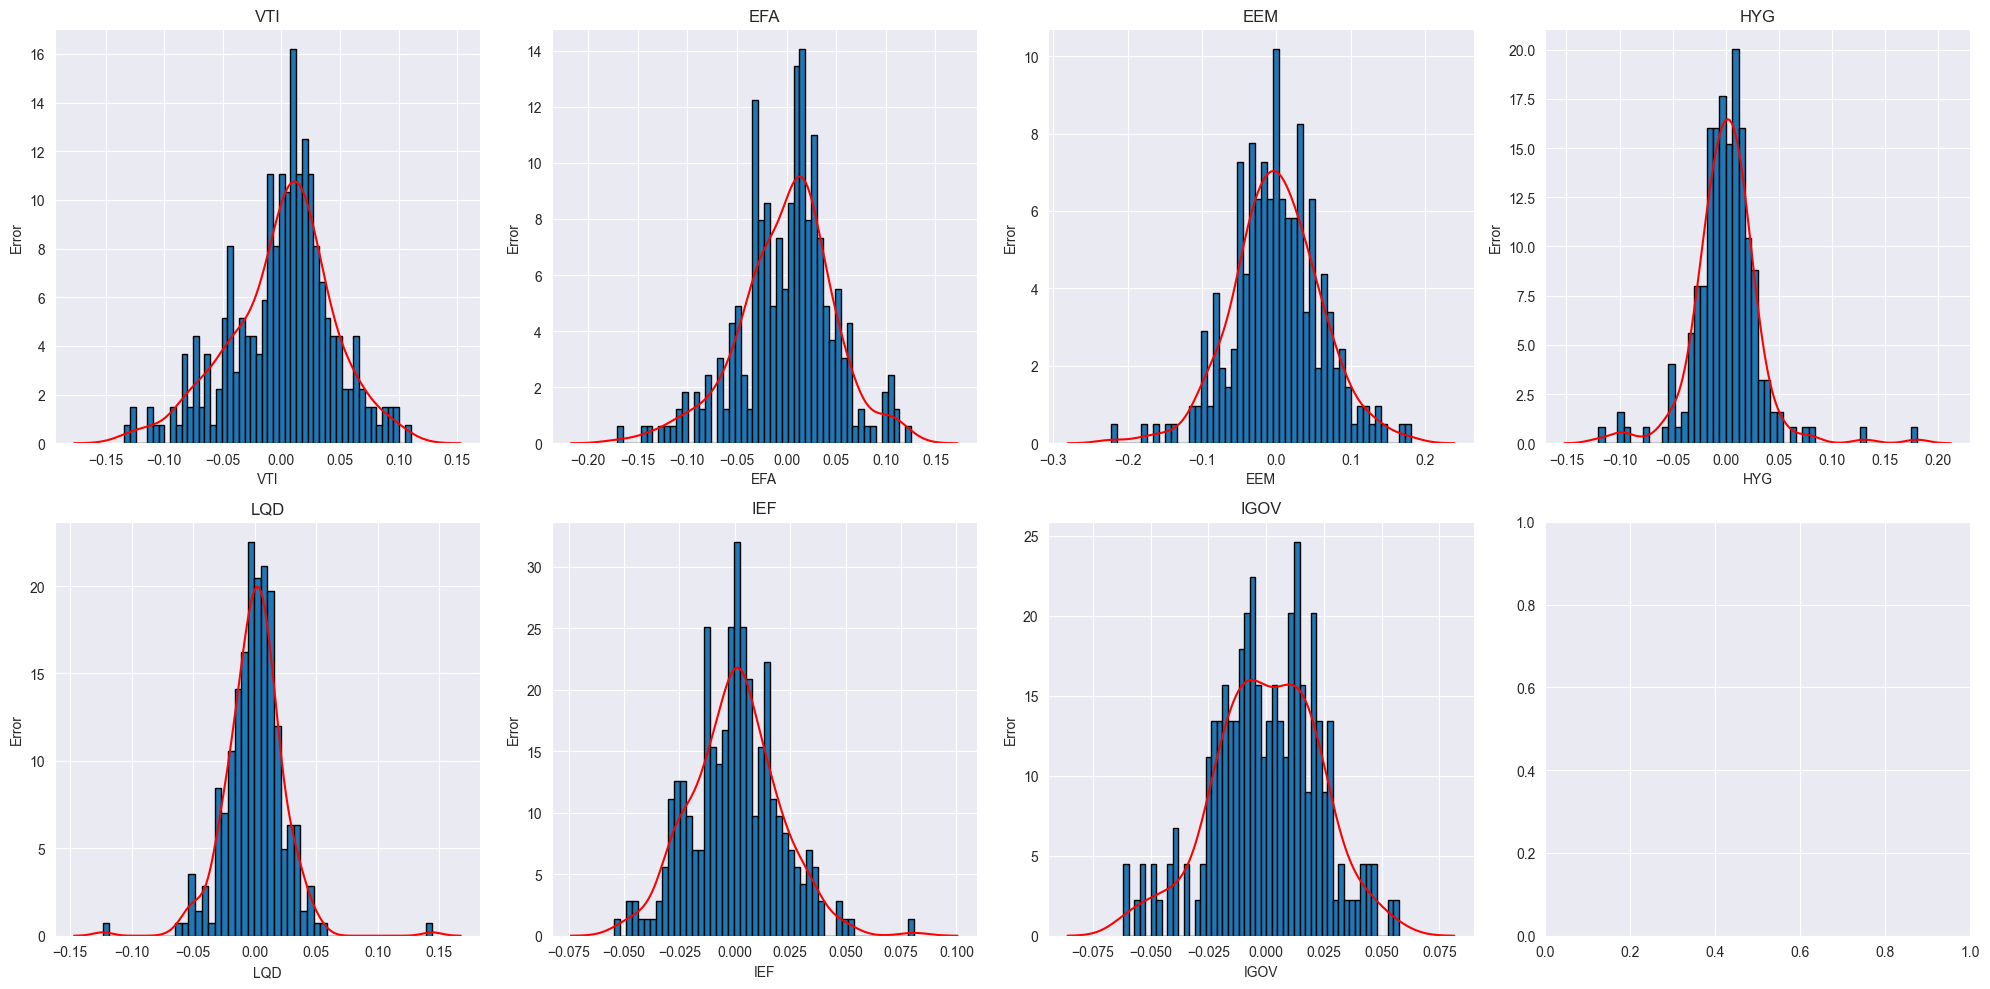

In [51]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, asset in enumerate(asset_classes):
    ax[i//4, i%4].hist(errors[asset], bins=50, edgecolor='black', density=True)
    sns.kdeplot(errors[asset], ax=ax[i//4, i%4], color='red')
    ax[i//4, i%4].set_title(asset)
    ax[i//4, i%4].set_ylabel('Error')
    ax[i//4, i%4].grid(True)

plt.tight_layout()
plt.show()

# Rolling regression

In [64]:
def rolling_factor_model_regression(df, etfs, window):
    # Create an empty dictionary to hold DataFrames for each ETF's rolling betas
    rolling_betas = {etf: pd.DataFrame(columns=['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], index=df.index[window - 1:]) for etf in etfs}
    rsquared_df = pd.DataFrame(index=df.index[window - 1:], columns=etfs)

    for etf in etfs:
        for start in range(len(df) - window + 1):
            # Define the rolling window subset
            window_df = df.iloc[start:start + window].dropna(subset=[etf, 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])
            
            # Ensure that the window has enough data points for regression
            if len(window_df) < window:
                continue  # Skip if not enough data
            
            # Define the dependent and independent variables
            y = window_df[etf]
            X = sm.add_constant(window_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
            
            # Perform the regression
            model = sm.OLS(y, X).fit()
            
            # Save the betas as a new row in the rolling_betas DataFrame for the current date
            rolling_betas[etf].loc[window_df.index[-1]] = model.params
            rsquared_df.loc[window_df.index[-1], etf] = model.rsquared

    # Combine betas into a multi-index DataFrame for easier analysis
    betas_df = pd.concat(rolling_betas, axis=1)
    
    return betas_df, rsquared_df

In [65]:
# Define the rolling window in months
window_months = 36
rolling_betas, rolling_r_squared = rolling_factor_model_regression(monthly_data, asset_classes, window_months)

In [67]:
rolling_betas.tail()

VTI                                                    \
               const    Mkt-RF       SMB       HML       RMW       CMA   
2024-04-30  0.010184  2.785014 -1.354798 -0.006691  3.121243  2.624274   
2024-05-31  0.006623  2.374184 -1.377828  0.068418  2.745889  1.570944   
2024-06-30  0.007802  2.475005 -1.233952  0.167983  2.771913  1.816851   
2024-07-31   0.00434  1.929171 -0.914638  1.058685  2.266617 -0.175362   
2024-08-31  0.002457  1.879713 -0.817036  0.869769  2.487157 -0.109169   

                 EFA                                ...       IEF            \
               const    Mkt-RF       SMB       HML  ...       SMB       HML   
2024-04-30  0.004701  3.033119 -0.843447 -0.156663  ... -0.107969 -1.361289   
2024-05-31  0.001437  2.812729 -0.657061 -0.163578  ... -0.025097 -1.355025   
2024-06-30  0.002363  2.874386 -0.771896 -0.397059  ...  0.106732 -1.201964   
2024-07-31 -0.000871  2.357498 -0.467448  0.439405  ...  0.169642  -0.81968   
2024-08-31  -0.00198  2.339052 -0.458867  0.339357  ...  0.110558 -0.841237   

                                    IGOV                                \
                 RMW       CMA     const    Mkt-RF       SMB       HML   
2024-04-30   2.71159   1.07816 -0.011062  2.124891 -0.901253 -1.280165   
2024-05-31  2.585141  0.717612 -0.013904  1.896803 -0.786986 -1.268644   
2024-06-30  2.457235   0.77326 -0.012494  2.013019 -0.671974 -1.227652   
2024-07-31  2.129734  0.059745 -0.015406  1.687403 -0.520986 -0.562525   
2024-08-31   2.15297  0.094654 -0.015675  1.704246 -0.616621 -0.564557   

                                
                 RMW       CMA  
2024-04-30  2.343356  1.846918  
2024-05-31  2.153601  1.306496  
2024-06-30  2.269132  1.608983  
2024-07-31  1.761297  0.288268  
2024-08-31  1.761012  0.326644  

[5 rows x 42 columns]

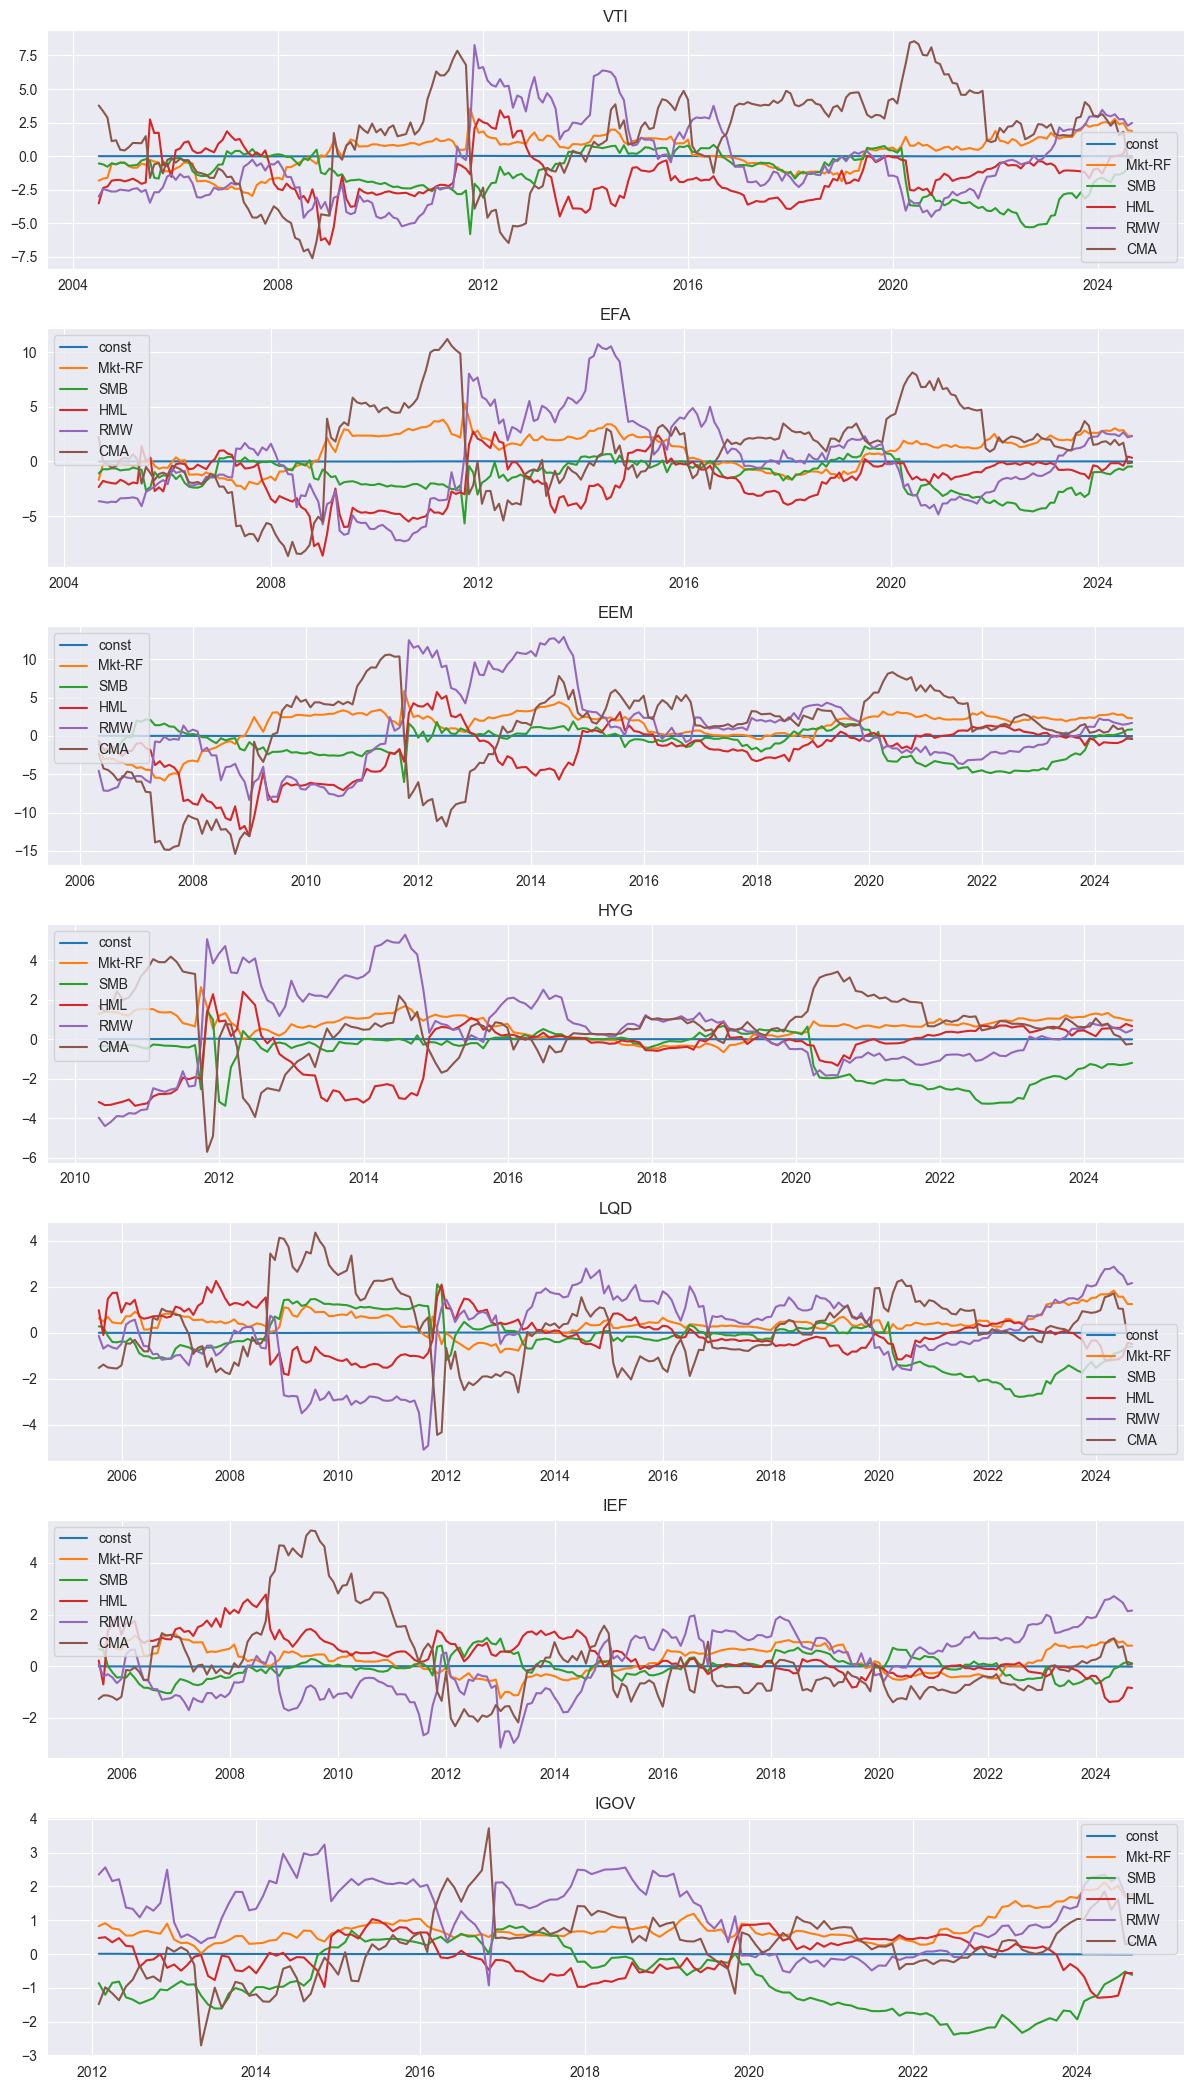

In [78]:
# Plot the 5 rolling betas for each of the ETFs in one plot each of 12x3 size each plot
fig, ax = plt.subplots(7, 1, figsize=(12, 21))

for i, asset in enumerate(asset_classes):
    ax[i].plot(rolling_betas[asset])
    ax[i].set_title(asset)
    ax[i].grid(True)
    ax[i].legend(rolling_betas[asset].columns)
    
plt.tight_layout()
plt.show()